# Creating density fields

[![Binder](https://mybinder.org/badge_logo.svg)](https://binder.flatironinstitute.org/v2/user/fvillaescusa/Quijote?filepath=/Tutorials/Density_fields.ipynb)

In [1]:
import numpy as np
import readgadget
import MAS_library as MASL

Define the value of the parameters

In [2]:
snapshot = '/home/jovyan/Data/Snapshots/fiducial/0/snapdir_004/snap_004' #location of the snapshot
grid     = 512    #the density field will have grid^3 voxels
MAS      = 'CIC'  #Mass-assignment scheme:'NGP', 'CIC', 'TSC', 'PCS'
verbose  = True   #whether to print information about the progress
ptype    = [1]    #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

Read the header and the particle positions

In [3]:
# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
redshift = header.redshift     #redshift of the snapshot
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h

# read positions, velocities and IDs of the particles
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h

Print some information about the data

In [4]:
print('BoxSize: %.3f Mpc/h'%BoxSize)
print('Redshift: %.3f'%redshift)
print('%.3f < X < %.3f'%(np.min(pos[:,0]), np.max(pos[:,0])))
print('%.3f < Y < %.3f'%(np.min(pos[:,1]), np.max(pos[:,1])))
print('%.3f < Z < %.3f'%(np.min(pos[:,2]), np.max(pos[:,2])))

BoxSize: 1000.000 Mpc/h
Redshift: 0.000
0.000 < X < 999.992
0.000 < Y < 999.992
0.000 < Z < 999.992


Define the matrix that will contain the value of the density / overdensity field

In [5]:
delta = np.zeros((grid,grid,grid), dtype=np.float32)

Now construct the 3D density field

In [6]:
# construct 3D density field
MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose)


Using CIC mass assignment scheme
Time taken = 6.275 seconds



We can make some tests to make sure the density field has been computed properly

In [7]:
# the sum of the values in all voxels should be equal to the number of particles
print('%.3f should be equal to\n%.3f'%(np.sum(delta, dtype=np.float64), pos.shape[0]))

134217728.019 should be equal to
134217728.000


As this point, delta contains the effective number of particles in each voxel. 
If you want instead the effective mass in each voxel you can just do

In [8]:
delta *= Masses[1]

# now check that the mass in the density field is equal to the total mass in the simulation
print('%.3e should be equal to\n%.3e'%(np.sum(delta, dtype=np.float64), pos.shape[0]*Masses[1]))

8.812e+19 should be equal to
8.812e+19


Lets take a slice in the cube and plot it

Image shape: (512, 512)
0.000e+00 < mass < 1.504e+14
0.000 < X < 10.000
0.000 < Y < 999.992
0.000 < Z < 999.992


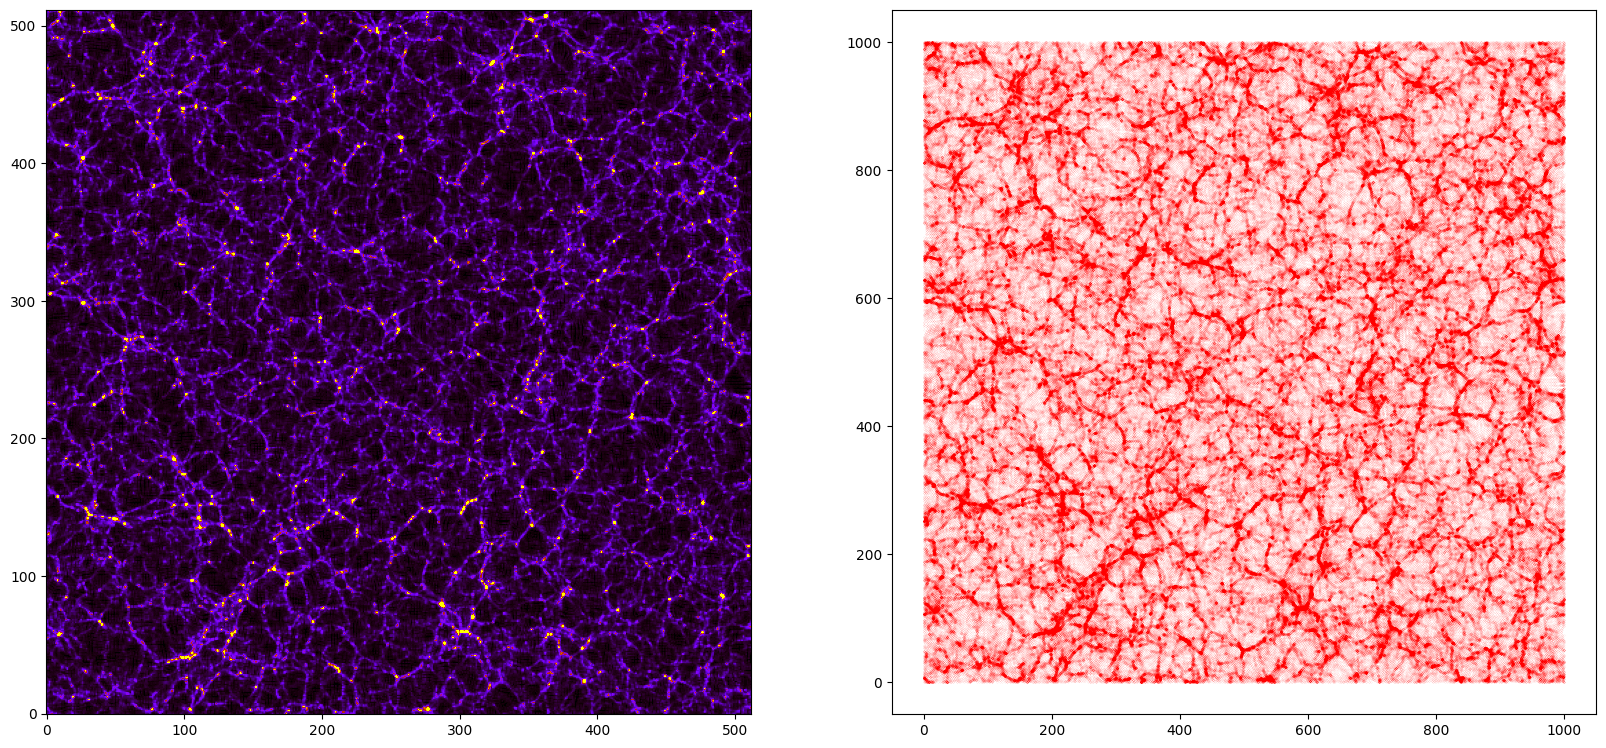

In [9]:
# the box is 1000 Mpc/h and every voxel has ~2 Mpc/h size. We can take ~5 slices to consider a region with a ~10 Mpc/h witdh
mean_density = np.mean(delta[:5,:,:],axis=0) #Take the first 5 component along the first axis and compute the mean value
print('Image shape:',mean_density.shape)
print('%.3e < mass < %.3e'%(np.min(mean_density), np.max(mean_density)))

# now lets consider the particles in that slide
indexes = np.where((pos[:,0]<10))
pos_slide = pos[indexes]
print('%.3f < X < %.3f'%(np.min(pos_slide[:,0]), np.max(pos_slide[:,0])))
print('%.3f < Y < %.3f'%(np.min(pos_slide[:,1]), np.max(pos_slide[:,1])))
print('%.3f < Z < %.3f'%(np.min(pos_slide[:,2]), np.max(pos_slide[:,2])))

import matplotlib.pyplot as plt
from pylab import *
fig = figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ax1.imshow(mean_density.T, cmap='gnuplot',vmin=0.0, vmax=1e13, origin='lower')
ax2.scatter(pos_slide[:,1], pos_slide[:,2], s=0.001,c='r')
plt.show()

If needed, the overdensity is easy to calculate

In [10]:
# at this point, delta contains the effective number of particles in each voxel
# now compute overdensity and density constrast
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

print('%.3f < delta < %.3f'%(np.min(delta), np.max(delta)))
print('<delta> = %.3f'%np.mean(delta))
print('shape of the matrix:', delta.shape)
print('density field data type:', delta.dtype)

-1.000 < delta < 1195.511
<delta> = -0.000
shape of the matrix: (512, 512, 512)
density field data type: float32


### Lets now compute density fields in redshift-space

Define the value of the parameters

In [11]:
import redshift_space_library as RSL

snapshot = '/home/jovyan/Data/Snapshots/Mnu_p/0/snapdir_003/snap_003' #location of the snapshot
grid     = 512    #the density field will have grid^3 voxels
MAS      = 'CIC'  #Mass-assignment scheme:'NGP', 'CIC', 'TSC', 'PCS'
axis     = 0      #axis along which to move particles to redshift-space (0-X), (1-Y), (2-Z)
verbose  = True   #whether to print information about the progress

Lets read the header and the particle positions and masses (for both dark matter and neutrinos)

In [12]:
# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

# read positions and velocities of the particles
pos_c = readgadget.read_block(snapshot, "POS ", [1])/1e3 #positions in Mpc/h
pos_n = readgadget.read_block(snapshot, "POS ", [2])/1e3 #positions in Mpc/h
vel_c = readgadget.read_block(snapshot, "VEL ", [1])     #velocities in km/s
vel_n = readgadget.read_block(snapshot, "VEL ", [2])     #velocities in km/s

Print some information about the data read

In [13]:
print('BoxSize = %.3f Mpc/h'%BoxSize)
print('Rdshift = %.3f'%redshift)
print('Mass DM = %.3e'%Masses[1])
print('Mass NU = %.3e'%Masses[2])
print('%.3f < X_DM < %.3f'%(np.min(pos_c[:,0]), np.max(pos_c[:,0])))
print('%.3f < Y_DM < %.3f'%(np.min(pos_c[:,1]), np.max(pos_c[:,1])))
print('%.3f < Z_DM < %.3f'%(np.min(pos_c[:,2]), np.max(pos_c[:,2])))
print('%.3f < X_NU < %.3f'%(np.min(pos_n[:,0]), np.max(pos_n[:,0])))
print('%.3f < Y_NU < %.3f'%(np.min(pos_n[:,1]), np.max(pos_n[:,1])))
print('%.3f < Z_NU < %.3f'%(np.min(pos_n[:,2]), np.max(pos_n[:,2])))

BoxSize = 1000.000 Mpc/h
Rdshift = 0.500
Mass DM = 6.516e+11
Mass NU = 4.930e+09
0.000 < X_DM < 999.992
0.000 < Y_DM < 999.992
0.000 < Z_DM < 999.992
0.000 < X_NU < 999.992
0.000 < Y_NU < 999.992
0.000 < Z_NU < 999.992


Now lets move particles to redshift space along the X-axis

In [14]:
# move dark matter particles to redshift-space
RSL.pos_redshift_space(pos_c, vel_c, BoxSize, Hubble, redshift, axis)

# move neutrino particles to redshift-space
RSL.pos_redshift_space(pos_n, vel_n, BoxSize, Hubble, redshift, axis)

Now construct the density field of matter (DM+NU) 

In [15]:
# define the matrix holding the density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)

# define two arrays with the masses of the DM and NU particles
mass_c = np.ones(pos_c.shape[0], dtype=np.float32)*Masses[1]
mass_n = np.ones(pos_n.shape[0], dtype=np.float32)*Masses[2]

# construct the density field
MASL.MA(pos_c, delta, BoxSize, MAS, W=mass_c, verbose=verbose)
MASL.MA(pos_n, delta, BoxSize, MAS, W=mass_n, verbose=verbose)


Using CIC mass assignment scheme with weights
Time taken = 5.882 seconds


Using CIC mass assignment scheme with weights
Time taken = 26.614 seconds



Make some checks

In [16]:
# check the total mass in the density field
Mtot1 = np.sum(delta, dtype=np.float64)
Mtot2 = np.sum(mass_c, dtype=np.float64) + np.sum(mass_n, dtype=np.float64)
print('%.3e should be equal to\n%.3e'%(Mtot1,Mtot2))

8.812e+19 should be equal to
8.812e+19


If needed, the overdensity field can be easily computed

In [17]:
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0
print('%.3f < delta < %.3f'%(np.min(delta), np.max(delta)))
print('<delta> = %.3f'%np.mean(delta))

-1.000 < delta < 98.331
<delta> = 0.000


Lets plot the density field along three different projections to see the effect of the redshift-space distortions

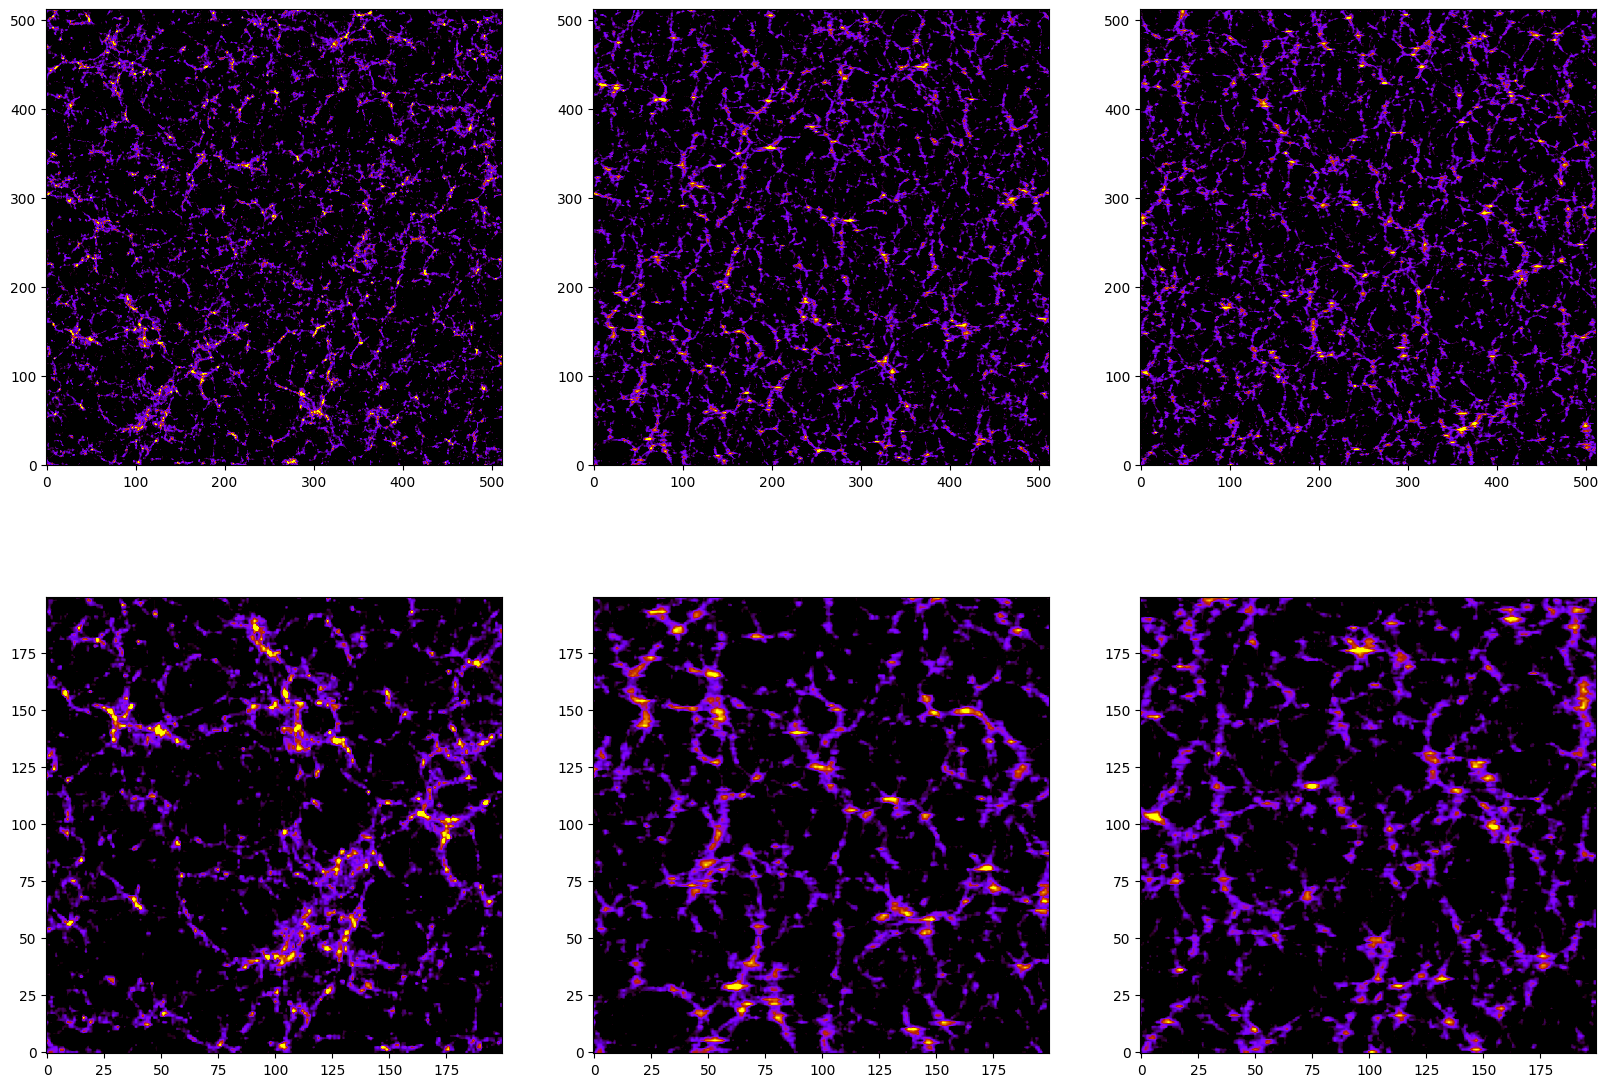

In [18]:
df_x = np.mean(delta[:5,:,:]+1,axis=0) #projection into the YZ plane
df_y = np.mean(delta[:,:5,:]+1,axis=1) #projection into the XZ plane
df_z = np.mean(delta[:,:,:5]+1,axis=2) #projection into the XY plane

import matplotlib.pyplot as plt
from pylab import *
fig = figure(figsize=(20,14))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
ax1.imshow(df_x.T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
ax2.imshow(df_y.T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
ax3.imshow(df_z.T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
ax4.imshow(df_x[:200,:200].T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
ax5.imshow(df_y[:200,:200].T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
ax6.imshow(df_z[:200,:200].T, cmap='gnuplot',vmin=1, vmax=10, origin='lower')
plt.show()

As can be seen, the images in the middle and right columns are blurrier than the ones of the left column. This is due to the effects of the redshift-space distortions along that are placed along the X axis.